# CNN  - This is a Convolutional Neural Network example using Keras

    Copyright (C) 2020 Adrian Bevan, Queen Mary University of London

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.
    
----------------------

CNN example using a Keras model. This is a simple example of a 2-conv layer with max pooling CNN example that has fully connected (Dense) layers following prior to the output prediction. This example is used for processing the MNIST (or CFAR10) data using the Adam optimiser. 

For more information about the Adam optimiser please see the  paper by Kingma and Ba, [arXiv:1412.6980](https://arxiv.org/abs/1412.6980).

## Useful background on MNIST and data wrangling

Set `UseMNIST = True` to train on the MNIST data.

The MNIST data is a set of 60,000 training and 10,000 test examples.  Each example is a hand written integer between 0 and 9, represented by a greyscale image with 28x28 pixels. This constitutes a 784 dimensional input feature space, where each image is a number between 0 and 255 (8 bit greyscale).  
 
For more information about the MNIST data set please see the website http://yann.lecun.com/exdb/mnist/.

## Useful background on CFAR10

Set `UseMNIST = False` to train on the CFAR10 data.

The CFAR10 data is a set of 60000 training and 50000 test examples. Each example is one of 10 categories, and is represented by colour image with 32x32 pixels.  This constitutes a 3072 dimensional input feature space (32x32x3), where each feature is an 8bit colour representation, i.e. a number between 0 and 255.  The 10 categories are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck.

For more information about the CFAR10 (and CFAR100) data set please see the website https://www.cs.toronto.edu/~kriz/cifar.html.


## Data Wrangling

In order for an image to be processed efficiently by a neural network the pixel colour in the range $[0, 255]$ is mapped into the domain $[0, 1]$, following the usual [Efficient Backpropagation](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf) data wrangling guidelines. For an MLP the 28x28 pixel image features (i.e. the pixels) are considered a linear set of 784 features that are input to the network.


----------------------
## Load and pre-process the data

The MNIST data are directly accessible via keras as a dataset. So we first load the data. As noted above (and as you will have explored in the linear regression example), it is important to closely match the weights used in a network with the feature space domain that is being studied, so that the optimiser has less work to do in order to converge to the optimal solution.  In this case we achieve that by mapping the 8-bit greyscale color value $[0, 255]$ on the domain $[0, 1]$.

In [20]:
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from tensorflow import keras

def getCFAR10():
    print("\033[92mLoading the CFAR10 data from keras\033[0m")
    # Load the CFAR10 data via the tensorflow keras dataset:
    cifar10 = keras.datasets.cifar10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0

    return x_train, y_train, x_test, y_test

def getMNIST():
    print("\033[92mLoading the MNIST data from keras\033[0m")
    # Load the MNIST data via the tensorflow keras dataset:
    mnist = keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    
    return x_train, y_train, x_test, y_test

#UseMNIST = False 
UseMNIST = True 

x_train = None
y_train = None
x_test  = None
y_test  = None
if UseMNIST:
    x_train, y_train, x_test, y_test = getMNIST()
    x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
    x_test  = x_test.reshape((x_test.shape[0], 28, 28, 1))

else:
    x_train, y_train, x_test, y_test = getCFAR10()

print("\tN(train)             = ", len(x_train))
print("\tN(test)              = ", len(x_test))
print("\tTest data shape      = ", x_train.shape )
print("\tTrain data shape     = ", x_test.shape )


Loading the CFAR10 data from keras
	N(train)             =  50000
	N(test)              =  10000
	Test data shape      =  (50000, 32, 32, 3)
	Train data shape     =  (10000, 32, 32, 3)


---------------------
## Building the model 

**Training [Epochs, batches and validation data]** The number of training epochs specified is denoted by `Nepochs`.  1 epoch is required to run over all of the training data.  It is possible to run batches or mini-batches of data through the training; each batch requires the optimisation to be performed, and so when specifying the `BatchSize` the training will be performed by running the optimisation $N_{epochs}\times N_{batches}$ times.  In general this leads to faster optimisation of the model than optimising over the full training set each time.

The training data will be split into training and validation samples according to the value of the variable `ValidationSplit`. 

**Dropout:** Coadaptation is the ability for an optimisation algorithm to allow weights to be learned where changes in one node can be compensated by changes in another node that limit the increase in performance.  This issue can be a problem for deep networks in particular where the optimisation process can involve millions of hyperparameters.  A way to combat this issue is to randomly drop-out nodes in the network each iteration of the optimisation.  That way no single paring of nodes can learn to co-adapt to the evolution of hyperparameters through the optimisation.  Thankfully all the user has to do is to set a dropout value via the variable `DropoutValue`. 

**NOTE:** this value is the fraction of nodes dropped from the model [In V1.X of TensorFlow the opposite convention was used].

**Loss:** The cross entropy loss function is used for this optimisation process.  The value of the loss function is converted into an output vector of 1's and 0's to be used for classification.

### Model configuration



In [22]:
#
# Training configuration
#
ValidationSplit = 0.5
BatchSize       = 20
Nepochs         = 20
DropoutValue    = 0.6

#
# as CFAR10 and MNIST are different shapes, extract the shape parameters to properly
# configure the CNN input data
#
xpix = x_train.shape[1]
ypix = x_train.shape[2]
zpix = x_train.shape[3] # color channels


model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(xpix, ypix, zpix)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(10))

print("--------------------------------------------------------------------------------------------------------------")
print("\033[92mWill train a convolutional neural network on the MNIST data\033[0m")
print("--------------------------------------------------------------------------------------------------------------\n\n")
print("Input data MNIST")
print("Dropout values       = ", DropoutValue)
print("Leaky relu parameter =  0.1")
print("ValidationSplit      = ", ValidationSplit)
print("BatchSize            = ", BatchSize)
print("Nepochs              = ", Nepochs, "\n")
print("N(train)             = ", len(x_train))
print("N(test)              = ", len(x_test))
model.summary()

# now specify the loss function - cross entropy
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# now we can train the model to make predictions.
#   Use the ADAM optimiser
#   Specify the metrics to report as accuracy
#   Specify the loss function (see above)
# the fit step specifies the number of training epochs
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
history  = model.fit(x_train, y_train, validation_split=ValidationSplit, batch_size=BatchSize, epochs=Nepochs)


--------------------------------------------------------------------------------------------------------------
Will train a convolutional neural network on the MNIST data
--------------------------------------------------------------------------------------------------------------


Input data MNIST
Dropout values       =  0.6
Leaky relu parameter =  0.1
ValidationSplit      =  0.5
BatchSize            =  20
Nepochs              =  20 

N(train)             =  50000
N(test)              =  10000
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 64)        18496     
_______________

------------
## Output

When training a model we are interested in studying the accuracy of prediction (in this case how often do we correctly classify an MNIST image according to its true label), and about the evolution of the loss function for both the test and train samples of examples.  If the test and train sample loss functions are signficantly different that points toward a problem... the model could be under or over trained.

This information is stored in the 'history' variable.  See the note regarding key value differences between TF1.0 and TF2.0 (here we use the TF2.0 convention).

history keys =  dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

Display the evolution of the accuracy as a function of the training epoch
  N(Epochs)        =  20
  accuracy (train) =  [0.39352, 0.53904, 0.59832, 0.6356, 0.66844, 0.69384, 0.71332, 0.73884, 0.7612, 0.77976, 0.79892, 0.81436, 0.83312, 0.84596, 0.86472, 0.87724, 0.88932, 0.89896, 0.90996, 0.91672]
  accuracy (test)  =  [0.51268, 0.56992, 0.602, 0.62172, 0.61164, 0.64688, 0.64384, 0.6594, 0.65572, 0.65752, 0.64404, 0.66044, 0.65728, 0.64988, 0.64076, 0.6514, 0.64204, 0.62552, 0.6418, 0.63676]


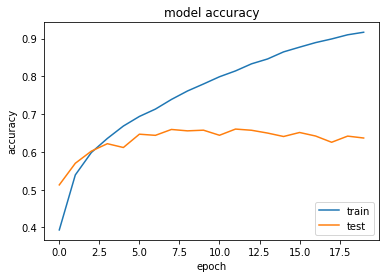


Display the evolution of the loss as a function of the training epoch
  N(Epochs)        =  20
  loss (train)     =  [1.6431989358901977, 1.2879870932102204, 1.134691210746765, 1.0327130084991456, 0.9473109639883042, 0.8705201178789139, 0.8103752075672149, 0.7450124304056167, 0.6800766021490097, 0.6262944065451622, 0.5714903658688069, 0.5258866224765778, 0.4700648437976837, 0.4285684912711382, 0.3780304946839809, 0.3443226370096207, 0.30282195417732, 0.28084972836971284, 0.25124409161806105, 0.23244718330577016]
  loss (test)      =  [1.354572101211548, 1.2087963871002196, 1.1307014819145202, 1.0741981199264525, 1.129902469611168, 1.039162723350525, 1.044469540119171, 1.0144701118707657, 1.0704845014810562, 1.0572300198316573, 1.1229827613592147, 1.124242954337597, 1.2145586532920598, 1.2593564941048623, 1.3681133652210236, 1.3968970380187034, 1.5756637911319733, 1.6396434968709945, 1.6977171173334122, 1.746504265332222]


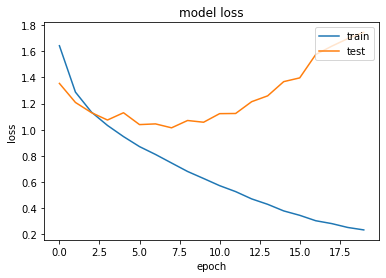


Performance summary (on test data):
10000/10000 - 1s - loss: 1.7579 - acc: 0.6331
	loss = 1.758
	accuracy = 0.633


In [23]:
import matplotlib.pyplot as plt

# Print out the history keys expected are:
#    loss        The loss function evaluated at each epoch for the training set
#    acc         The accuracy evaluated at each epoch for the training set
#    val_loss    The loss evaluated at each epoch for the validation set
#    val_acc     The accuracy evaluated at each epoch for the validation set
# The val_* entries exist only if there is a validation_split specified
#
# NOTE: TFV1.0 uses acc and val_acc keys instead of accuracy and val_accuracy
#
print("history keys = ", history.history.keys())

print("\n\033[1mDisplay the evolution of the accuracy as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)
print("  accuracy (train) = ", history.history['acc'])
print("  accuracy (test)  = ", history.history['val_acc'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
#print("  accuracy (train) = ", history.history['accuracy'])
#print("  accuracy (test)  = ", history.history['val_accuracy'])
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
plt.clf()

print("\n\033[1mDisplay the evolution of the loss as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)
print("  loss (train)     = ", history.history['loss'])
print("  loss (test)      = ", history.history['val_loss'])

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# having finished training the model, use this to evaluate the performance on a sample of test data
print("\n\033[1mPerformance summary (on test data):\033[0m")
loss, acc = model.evaluate(x_test,  y_test, verbose=2)
print("\tloss = {:5.3f}\n\taccuracy = {:5.3f}".format(loss, acc))


----------------------
## Suggested exercises:

 - Explore the effect of DropOut, ValidationSplit, Nepochs, and BatchSize have on the training (try to find a model where the test and train loss function values are similar.
 - Explore how the CNN affects the training performance e.g. 
   - change the number of convolution filters in each layer.  The current values of these are 32, 64 and 64
   - change the number of nodes in the fully connected (Dense) layer. The current value of nodes in this layer is 64.
 - Explore the effect of adding a second dropout layers into the network after the conv and Dense layers (see the NN.ipynb example for how to implement a dense layer in a model.